In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from proj1_helpers import load_csv_data, predict_labels, create_csv_submission
from implementations import least_squares, least_squares_GD, least_squares_SGD, compute_loss_ls, ridge_regression, ridge_GD, ridge_SGD, logistic_regression, reg_logistic_regression
from preprocessing import standardize_train, standardize_test, add_bias
from other import remove_999
from plots import plot_train_test
import math

## Load data

In [3]:
y_train, input_train, ids_train = load_csv_data('train.csv', sub_sample=False)
y_test, input_test, ids_test = load_csv_data('test.csv', sub_sample=False)

In [4]:
y_train

array([ 1., -1., -1., ...,  1., -1., -1.])

In [5]:
input_train

array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ..., -999.   , -999.   ,   46.226],
       [-999.   ,  162.172,  125.953, ..., -999.   , -999.   ,   44.251],
       ..., 
       [ 105.457,   60.526,   75.839, ..., -999.   , -999.   ,   41.992],
       [  94.951,   19.362,   68.812, ..., -999.   , -999.   ,    0.   ],
       [-999.   ,   72.756,   70.831, ..., -999.   , -999.   ,    0.   ]])

## Pre-processing

In [6]:
# Careful to standardize the x_test with the mean and std of x_train
x_train_no_999, y_train_no_999 = remove_999(input_train, y_train)

x_train_no_999, mean, std = standardize_train(x_train_no_999)
x_train_no_999 = add_bias(x_train_no_999)

x_test = standardize_test(input_test, mean, std)
x_test = add_bias(x_test)   ###### Verifier si il faut add bias au test set

In [7]:
print(x_train_no_999.shape[0])
print(y_train_no_999.shape)

68114
(68114,)


## Constant definitions

In [8]:
nb_fold = 10

In [9]:
# Define the parameters of the algorithm. (probably change afterwards)
max_iters = 1000   #les plots sont moches parce que j'ai fait avec 20 ici                                  
batch_size = 1

# Initialization
w_initial = np.random.rand(x_train_no_999.shape[1])

In [10]:
# For grid search of hyperparameters
num_intervals = 10
gammas = np.linspace(0.005, 0.2, num_intervals)
#gammas = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5])
#lambdas = np.logspace(-4, -0.05, num_intervals)

In [32]:
def accuracy(w, x_test, y_test):
    y_pred = predict_labels(-w, x_test)
    accuracy = sum(y_pred == y_test)/len(y_test)
    return accuracy

In [33]:
w_ls, _ = least_squares(y_train_no_999, x_train_no_999)

In [34]:
accuracy_ls = accuracy(w_ls, x_test, y_test)

In [35]:
accuracy_ls  #(je pense que il fait l'inverse mais -1 pour 1 et 1 pour -1  ')

0.86578863082018453

## GD Least squares

In [29]:
def ls_gd_hyperparam(gammas, nb_fold, x_train, y_train):
    #print("y {}".format(y_train))
    loss_valid = np.zeros([len(gammas), nb_fold])
    loss_train = np.zeros([len(gammas), nb_fold])
    
    nb_elem = math.floor(x_train.shape[0]/nb_fold)
    
    for i, gamma in enumerate(gammas):
        for k in range(nb_fold):
            x_valid_k = x_train[k*nb_elem:(k+1)*nb_elem][:]  
            y_valid_k = y_train[k*nb_elem:(k+1)*nb_elem]
            
            x_train_k = np.concatenate([x_train[0:k*nb_elem][:], x_train[(k+1)*nb_elem:][:]])
            y_train_k = np.concatenate([y_train[0:k*nb_elem],    y_train[(k+1)*nb_elem:]   ]) 
                                        
            w, loss_tr = least_squares_GD(y_train_k, x_train_k, w_initial, max_iters, gamma)
            loss_train[i][k] = loss_tr
            loss_valid[i][k] = compute_loss_ls(y_valid_k, x_valid_k, w)
            
    return loss_valid, loss_train 

In [30]:
loss_valid_gd, loss_train_gd = ls_gd_hyperparam(gammas, nb_fold, x_train_no_999, y_train_no_999)

In [31]:
train_gd_mean = np.mean(loss_train_gd, axis=1)
valid_gd_mean = np.mean(loss_valid_gd, axis=1)

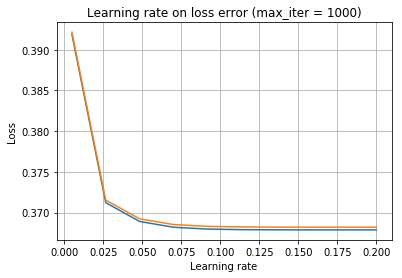

In [32]:
plot_train_test(train_gd_mean, valid_gd_mean, gammas)

In [33]:
# Minimum values for ls_gd
idx = np.argmin(valid_gd_mean)
learning_rate = gammas[idx]
ls_gd_loss = np.min(valid_gd_mean)
print(learning_rate)
print(ls_gd_loss)

0.2
0.36820105888729493


Test model

In [17]:
w_ls_gd, loss_tr = least_squares_GD(y_train_no_999, x_train_no_999, w_initial, max_iters=200, gamma=0.2)

In [18]:
accuracy_ls_gd = accuracy(w_ls_gd, x_test, y_test)
print(accuracy_ls_gd)

0.8621933063258705


# SGD Least squares

In [80]:

def ls_sgd_hyperparam(gammas, nb_fold, x_train, y_train):
    loss_valid = np.zeros([len(gammas), nb_fold])
    loss_train = np.zeros([len(gammas), nb_fold])
    
    nb_elem = math.floor(x_train.shape[0]/nb_fold)
    
    for i, gamma in enumerate(gammas):
        print(i)
        for k in range(nb_fold):
            x_valid_k = x_train[k*nb_elem:(k+1)*nb_elem][:]  
            y_valid_k = y_train[k*nb_elem:(k+1)*nb_elem]
            
            x_train_k = np.concatenate([x_train[0:k*nb_elem][:], x_train[(k+1)*nb_elem:][:]])
            y_train_k = np.concatenate([y_train[0:k*nb_elem],    y_train[(k+1)*nb_elem:]   ]) 
                                        
            w, loss_tr = least_squares_SGD(y_train_k, x_train_k, w_initial, max_iters, gamma)
            loss_train[i][k] = loss_tr
            loss_valid[i][k] = compute_loss_ls(y_valid_k, x_valid_k, w)
            
    return loss_valid, loss_train 

In [26]:
gammas = np.linspace(0.0001, 0.03, num_intervals)
loss_valid_sgd, loss_train_sgd = ls_sgd_hyperparam(gammas, nb_fold, x_train_no_999, y_train_no_999)

0
1
2
3
4
5
6
7
8
9


In [27]:
train_sgd_mean = np.mean(loss_train_sgd, axis=1)
valid_sgd_mean = np.mean(loss_valid_sgd, axis=1)

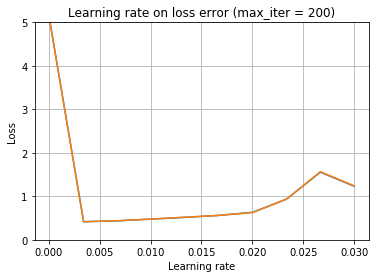

In [28]:
plot_train_test(train_sgd_mean, valid_sgd_mean, gammas)

In [29]:
# Minimum values for ls_sgd
idx = np.argmin(valid_sgd_mean)
learning_rate = gammas[idx]
ls_sgd_loss = np.min(valid_sgd_mean)
print(learning_rate)
print(ls_sgd_loss)

0.00342222222222
0.414967974107


In [36]:
w_ls_sgd, loss_tr = least_squares_SGD(y_train_no_999, x_train_no_999, w_initial, max_iters=200, gamma=0.0035)

In [37]:
accuracy_ls_sgd = accuracy(w_ls_sgd, x_test, y_test)
print(accuracy_ls_sgd)

0.813794571993


## DONC POUR SGD GAMMA = 0.0035
## POUR SG GAMMA = 0.2

## SGD Ridge regression

Peut etre trop long, plutot voir si on pose un 'bon' gamma, quel est le meilleur lambda.

Du coup, même fonction que avant pour hyperparam

In [186]:
#gammas = np.linspace(0.00001, 0.3, num_intervals)
lambdas = np.linspace(0.01, 20, 10)
gamma = 0.005
nb_fold = 20

In [187]:
def ridge_sgd_lambda(lambdas, nb_fold, x_train, y_train, gamma, x_test, y_test):
    accuracy_valid = np.zeros([len(lambdas), nb_fold])
    accuracy_train = np.zeros([len(lambdas), nb_fold])
    
    nb_elem = math.floor(x_train.shape[0]/nb_fold)
    
    
    for i, lambda_ in enumerate(lambdas):
        print(i)
        for k in range(nb_fold):
            x_valid_k = x_train[k*nb_elem:(k+1)*nb_elem][:]  
            y_valid_k = y_train[k*nb_elem:(k+1)*nb_elem]
            
            x_train_k = np.concatenate([x_train[0:k*nb_elem][:], x_train[(k+1)*nb_elem:][:]])
            y_train_k = np.concatenate([y_train[0:k*nb_elem],    y_train[(k+1)*nb_elem:]   ]) 
                                        
            w, loss_tr = ridge_SGD(y_train_k, x_train_k, w_initial, max_iters, gamma, lambda_)
            accuracy_train[i][k] = accuracy(w, x_train_k, y_train_k)
            accuracy_valid[i][k] = accuracy(w, x_test, y_test)
            
        train_sgd_mean = np.mean(accuracy_train, axis=1)
        valid_sgd_mean = np.mean(accuracy_valid, axis=1)

    return train_sgd_mean, valid_sgd_mean

In [188]:
valid_r_sgd, train_r_sgd = ridge_sgd_lambda(lambdas, nb_fold, x_train_no_999, y_train_no_999, gamma, x_test, y_test)

0
1
2
3
4
5
6
7
8
9


In [195]:
def plot_train_test_ridge(train_sgd_mean, valid_sgd_mean, lambdas):
    fig, ax = plt.subplots()
    ax.plot(lambdas, train_sgd_mean, label='Training set')
    ax.plot(lambdas, valid_sgd_mean, label = 'Testing set')

    ax.set(xlabel='Lambdas', ylabel='Loss',
           title='Lambda on accuracy (max_iter = 200)')
    ax.grid()
    plt.xticks(lambdas)
    plt.ylim((0, 1))
    
    plt.legend()
    fig.savefig("ridge_lambda_20fold_200maxiter_only999removed.png")
    plt.show()

In [196]:
print(lambdas)

[  1.00000000e-02   2.23111111e+00   4.45222222e+00   6.67333333e+00
   8.89444444e+00   1.11155556e+01   1.33366667e+01   1.55577778e+01
   1.77788889e+01   2.00000000e+01]


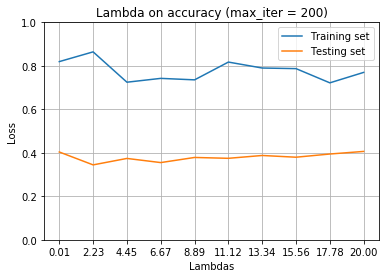

In [197]:
plot_train_test_ridge(train_r_sgd, valid_r_sgd, lambdas)

In [198]:
# Minimum values for ls_sgd
ind = np.unravel_index(np.argmin(valid_r_sgd, axis=None), valid_r_sgd.shape)
lambd = lambdas[ind]
ls_sgd_loss = valid_r_sgd[ind]
print(lambd)
print(ls_sgd_loss)

2.23111111111
0.344550989816


In [199]:
max_iters=200
gamma=0.005 #0.0035
lambda_ = 2.11 #to find
w_r_sgd, _ = ridge_SGD(y_train_no_999, x_train_no_999, w_initial, max_iters, gamma, lambda_)

lambda = 20 --> 0.85
         15 --> 0.85
         10 --> 0.87
         5  --> 0.85

In [200]:
accuracy_r_sgd = accuracy(w_r_sgd, x_test, y_test)
print(accuracy_r_sgd)

0.861945170862


## GD Ridge regression

In [ ]:
def ridge_gd_hyperparam(gammas, lambdas, nb_fold, x_train, y_train):
    loss_train = np.zeros([len(gammas), len(lambdas), nb_fold])
    loss_valid = np.zeros([len(gammas), len(lambdas), nb_fold])
    
    nb_elem = math.floor(x_train.shape[0]/nb_fold)
    
    for i, gamma in enumerate(gammas):
        for j, lambda_ in enumerate(lambdas):
            for k in range(nb_fold):
                
                x_valid_k = x_train[k*nb_elem:(k+1)*nb_elem][:]  
                y_valid_k = y_train[k*nb_elem:(k+1)*nb_elem]

                x_train_k = np.concatenate([x_train[0:k*nb_elem][:], x_train[(k+1)*nb_elem:][:]])
                y_train_k = np.concatenate([y_train[0:k*nb_elem],    y_train[(k+1)*nb_elem:]   ]) 

                w, loss_gamma = ridge_SGD(y_train_k, x_train_k, w_initial, max_iters, gamma, lambda_)
                loss_train[i][j][k] = loss_gamma
                loss_valid[i][j][k] = compute_loss_ridge(y_valid_k, x_valid_k, w, lambda_)
                
    return loss_train, loss_valid

In [ ]:
loss_valid_r_gd, loss_train_r_gd = ridge_gd_hyperparam(gammas, lambdas, nb_fold, x_train_no_999, y_train_no_999)

In [ ]:
train_gd_mean = np.mean(loss_train_r_gd, axis=2)
valid_gd_mean = np.mean(loss_valid_r_gd, axis=2)

In [ ]:
# Minimum values for ls_sgd
ind = np.unravel_index(np.argmin(valid_gd_mean, axis=None), valid_gd_mean.shape)
learning_rate = gammas[ind[0]]
ls_gd_loss = valid_gd_mean[ind]
print(learning_rate)
print(ls_gd_loss)

# Pas sûre des logistic regression. Voir correction lab05
Sinon toujours le même code et techniques que avant 

## Logistic regression
Debugged but not sure from here: Il y aura probablement une correction du labo 5 pour améliorer / vérifier les fonctions de logistic regression

## Regularized Logistic Regression

# Prediction de chaque méthode pour Kaggle

In [ ]:
y_pred = predict_labels(w, x_test)